In [3]:
import os
import matplotlib.pyplot as plt
os.chdir("../")

In [ ]:
import numpy

In [4]:
from evaluation.eval_utils import show_retrieval_metrics
import json
def load_examples(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)


In [9]:
custom_result = load_examples("results/qwen-100_lpert-5_qwen06-100_lpert-5_qwen4.json")
qwen_result = load_examples("results/qwen06-100_qwen06-5_qwen06-100_qwen06-5_qwen4.json")

In [6]:
result.keys()

dict_keys(['meta', 'retriever_scores', 'reranker_scores', 'line_retriever_scores', 'line_reranker_scores', 'reasoner_result', 'reasoner_score'])

In [21]:
def plot_pipeline_metrics_2x2(
    cutoff_list,
    doc_scores_dict,   # {"Retriever": ..., "Reranker": ...}
    line_scores_dict,  # {"Retriever": ..., "Reranker": ...}
    rerank_at_k = 5,
):
    """
    Plots a 2x2 comparison grid: (Doc-NDCG, Doc-Hit), (Line-NDCG, Line-Hit).
    Args:
        cutoff_list: List of cutoff values (n).
        doc_scores_dict: Dict of module name -> scores_at_n (for doc).
        line_scores_dict: Dict of module name -> scores_at_n (for line).
    """
    doc_labels=set(doc_scores_dict.keys())
    line_labels=set(line_scores_dict.keys())
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    # --- Doc NDCG
    for label in doc_labels:
        scores = doc_scores_dict[label]
        avg_ndcg = [sum(scores[n]["ndcg"]) / len(scores[n]["ndcg"]) for n in cutoff_list]
        axs[0, 0].plot(cutoff_list, avg_ndcg, marker='o', label=label)
    axs[0, 0].set_title("Document-level NDCG@n")
    axs[0, 0].set_xlabel("Top-n")
    axs[0, 0].set_ylabel("NDCG")
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    # --- Doc Hit Rate
    for label in doc_labels:
        scores = doc_scores_dict[label]
        avg_hit = [sum(scores[n]["hit"]) / len(scores[n]["hit"]) for n in cutoff_list]
        axs[0, 1].plot(cutoff_list, avg_hit, marker='o', label=label)
    axs[0, 1].set_title("Document-level HitRate@n")
    axs[0, 1].set_xlabel("Top-n")
    axs[0, 1].set_ylabel("Hit Rate")
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # --- Line NDCG
    for label in line_labels:
        scores = line_scores_dict[label]
        avg_ndcg = [sum(scores[n]["ndcg"]) / len(scores[n]["ndcg"]) for n in cutoff_list]
        axs[1, 0].plot(cutoff_list, avg_ndcg, marker='o', label=label)
    axs[1, 0].set_title("Line-level NDCG@n")
    axs[1, 0].set_xlabel("Top-n")
    axs[1, 0].set_ylabel("NDCG")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # --- Line Hit Rate
    for label in line_labels:
        scores = line_scores_dict[label]
        avg_hit = [sum(scores[n]["hit"]) / len(scores[n]["hit"]) for n in cutoff_list]
        axs[1, 1].plot(cutoff_list, avg_hit, marker='o', label=label)
    axs[1, 1].set_title("Line-level HitRate@n")
    axs[1, 1].set_xlabel("Top-n")
    axs[1, 1].set_ylabel("Hit Rate")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()



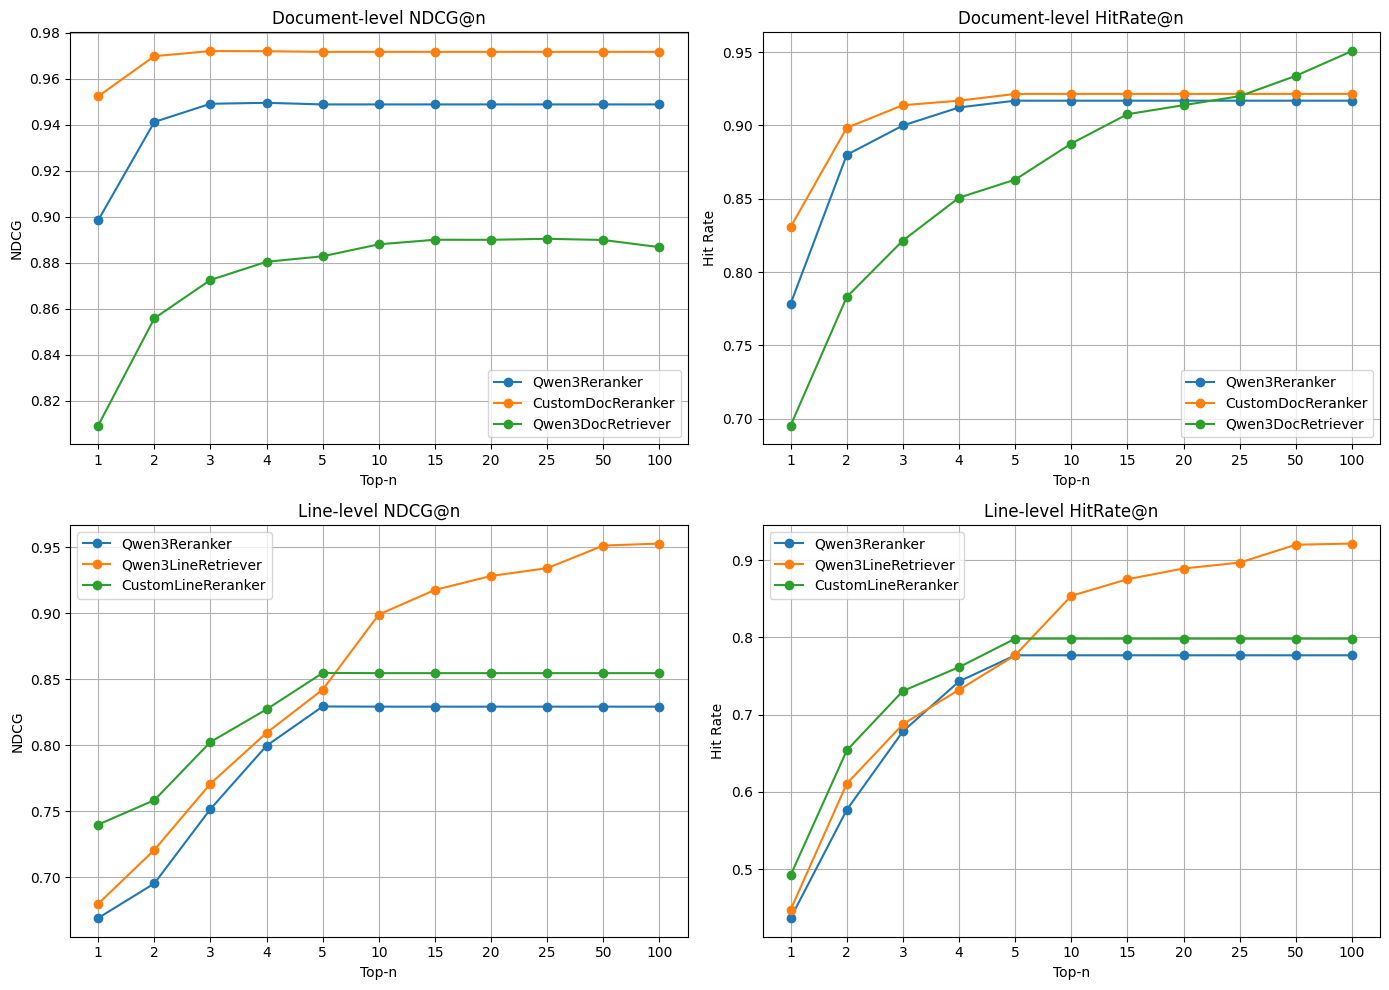

In [22]:
# --- Example usage ---
#custom_result,qwen_result
cutoff_list = [str(num) for num in result['meta']['cutoff_list']]
doc_scores_dict = {"Qwen3DocRetriever": custom_result['retriever_scores'],
                   "Qwen3Reranker": qwen_result['reranker_scores'],
                   "CustomDocReranker": custom_result['reranker_scores']}
line_scores_dict={"Qwen3LineRetriever": custom_result['line_retriever_scores'], 
                  "Qwen3Reranker": qwen_result['line_reranker_scores'],
                  "CustomLineReranker": custom_result['line_reranker_scores']}
# Example usage:
plot_pipeline_metrics_2x2(
    cutoff_list,
    doc_scores_dict=doc_scores_dict,
    line_scores_dict=line_scores_dict
)

In [32]:
def summarize_scores_table(
    cutoff_list,
    module_scores,
    label_modules=None,
    title="METRICS TABLE"
):
    """
    module_scores: dict of {module_name: {cutoff: {"ndcg": [...], "hit": [...]}}}
    label_modules: dict of {module_name: {"precision": ..., "recall": ..., "f1": ...}}
    """
    print(f"\n=== {title} ===\n")
    for module_name, scores_dict in module_scores.items():
        header = f"| {module_name:<15} |" + " {:>10} | {:>10} |".format("NDCG", "HitRate")
        print("-" * len(header))
        print(header)
        print("-" * len(header))
        for n in cutoff_list:
            ndcgs = scores_dict[n]["ndcg"]
            hits = scores_dict[n]["hit"]
            print("| @{:<13} | {:10.4f} | {:10.4f} |".format(
                n, sum(ndcgs)/len(ndcgs), sum(hits)/len(hits)
            ))
        print("-" * len(header))
    if label_modules:
        for module_name, metrics in label_modules.items():
            print(f"\n--- {module_name} Label Metrics ---")
            for k, v in metrics.items():
                if k =='labels':
                    continue
                if isinstance(v, list):
                    avg = sum(v) / len(v) if v else 0.0
                    print(f"{k.capitalize():<10}: {avg:.4f}")
                else:
                    print(f"{k.capitalize():<10}: {v:.4f}")
    print("=" * 50)

In [33]:
module_scores = {**doc_scores_dict, **line_scores_dict} 
label_modules = {
    "Reasoner": qwen_result['reasoner_score'],
}
cutoff_list = ['1', '5']

In [34]:
summarize_scores_table(
    cutoff_list=cutoff_list,
    module_scores=module_scores,
    label_modules=label_modules,
    title="FULL PIPELINE COMPARISON"
)


=== FULL PIPELINE COMPARISON ===

-----------------------------------------------
| Qwen3DocRetriever |       NDCG |    HitRate |
-----------------------------------------------
| @1             |     0.8092 |     0.6954 |
| @5             |     0.8828 |     0.8631 |
-----------------------------------------------
---------------------------------------------
| Qwen3Reranker   |       NDCG |    HitRate |
---------------------------------------------
| @1             |     0.6692 |     0.4369 |
| @5             |     0.8295 |     0.7769 |
---------------------------------------------
-----------------------------------------------
| CustomDocReranker |       NDCG |    HitRate |
-----------------------------------------------
| @1             |     0.9523 |     0.8308 |
| @5             |     0.9716 |     0.9215 |
-----------------------------------------------
------------------------------------------------
| Qwen3LineRetriever |       NDCG |    HitRate |
-----------------------------

In [21]:
show_retrieval_metrics(cutoff_list,result['line_reranker_scores'],)


=== Performance Table () ===
n      NDCG         Hit       
1      0.7400       0.4923    
2      0.7585       0.6538    
3      0.8026       0.7308    
4      0.8273       0.7615    
5      0.8548       0.7985    
10     0.8547       0.7985    
15     0.8547       0.7985    
20     0.8547       0.7985    
25     0.8547       0.7985    
50     0.8547       0.7985    
100    0.8547       0.7985    
